# Tips to speed up Python

## Contents
- [Hang on, don't optimise too early](#hang-on-don-t-optimise-too-early)
- [How fast is it?](#how-fast-is-it)
- [How fast could it go?](#how-fast-could-it-go)
- [Potential improvements](#potential-improvements)
  - [Append to lists, rather than concatenating](#append-to-lists-rather-than-concatenating)
  - [Move loop-invariants outside loops](#move-loop-invariants-outside-loops)
  - [Use built-in functions](#use-built-in-functions)
  - [Use optimal data types](#use-optimal-data-types)
  - [Reduce repeated calculations with caching](#reduce-repeated-calculations-with-caching)
  - [Use vectorisation instead of loops](#use-vectorisation-instead-of-loops)
  - [Algorithm improvements](#algorithm-improvements)
  - [Compilers](#compilers)
  - [Lazy loading and execution](#lazy-loading-and-execution)
  - [Parallelisation](#parallelisation)
    - [Single machine](#single-machine)
    - [Multi-threading](#multi-threading)
    - [Multi-processing](#multi-processing)
    - [Interactive on HPC](#interactive-on-hpc)
    - [HPC](#hpc)
    - [Profile parallel code](#profile-parallel-code)
    - [Suitable data types for parallel computing](#suitable-data-types-for-parallel-computing)
  - [GPUs](#gpus)
- [Recommendations](#recommendations)
- [Further information](#further-information)

## Hang on, don't optimise too early
- Trade-offs e.g. complexity, speed, memory, disk, readability, time, effort, etc.
    - Check that code is correct (tested, documented).
    - Is optimisation needed?
    - If yes, optimise code and data.
    - If more needed, parallelise.  

*Plot idea from [Dask-ML](https://ml.dask.org/).*

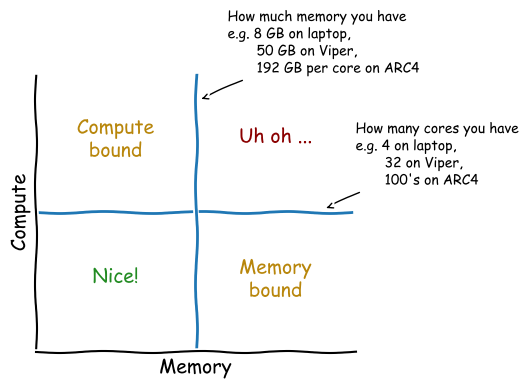

In [2]:
import matplotlib.pyplot as plt
import numpy as np

with plt.xkcd():
    fig = plt.figure(figsize=(4, 4), dpi=100)
    ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    plt.axhline(y=0.5, linestyle='-')
    plt.axvline(x=0.5, linestyle='-')
    ax.annotate('Compute\nbound', xy=(0.25, 0.7), ha='center', color='darkgoldenrod')
    ax.annotate('Memory\nbound', xy=(0.75, 0.2), ha='center', color='darkgoldenrod')
    ax.annotate('Nice!', xy=(0.25, 0.25), ha='center', color='forestgreen')
    ax.annotate('Uh oh ...', xy=(0.75, 0.75), ha='center', color='darkred')
    ax.annotate(
        "How many cores you have\ne.g. 4 on laptop,\n       32 on Viper,\n       100's on ARC4",
        arrowprops=dict(arrowstyle='->'),
        xy=(0.9, 0.51),
        xytext=(1, 0.6),
        fontsize=10
    )
    ax.annotate(
        "How much memory you have\ne.g. 8 GB on laptop,\n       50 GB on Viper,\n       192 GB per core on ARC4",
        arrowprops=dict(arrowstyle='->'),
        xy=(0.51, 0.9),
        xytext=(0.6, 1),
        fontsize=10
    )
    ax.set_xlabel('Memory')
    ax.set_ylabel('Compute')
    plt.show()

## How fast is it?
- [Profiling](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html) (i.e. find the bottlenecks)
  - [Speed](https://github.com/pyutils/line_profiler)
    - [IPython magic](https://jakevdp.github.io/PythonDataScienceHandbook/01.03-magic-commands.html) (Jupyter Lab)
      - Line: `%timeit`
      - Cell: `%%timeit`
      - If `pip install line_profiler`:
        - First load module: `%load_ext line_profiler`
        - Scripts: `%prun`
        - Line-by-line: `%lprun`
          - `@profile` decorator around the function
  - [Memory](https://github.com/pythonprofilers/memory_profiler)
    - If `pip install memory_profiler`:
    - First load module:
      - `%load_ext memory_profiler`
      - Line: `%memit`
      - Cell: `%%memit`
      - Line-by-line: `%mprun`
- [Profile parallel code](#Profile-parallel-code)

## How fast could it go?
- Time-space complexity
  - [Big O notation](https://www.bigocheatsheet.com/) where O is the order of operations, O(...).
  - Ignores constants and takes the largest order, so O(2n<sup>2</sup> + 3n) would be O(n<sup>2</sup>).
  - Important for large number of elements, N.
  - Typical case.
  - Constant time means per machine operation.
  
*Plot idea from [Big O Cheat Sheet](https://www.bigocheatsheet.com/)*

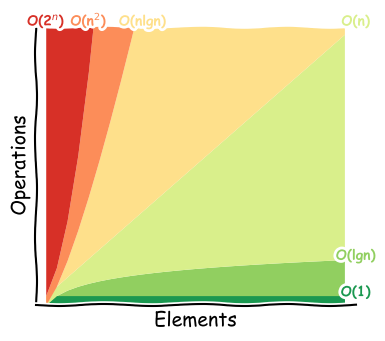

In [3]:
max_value = 30
elements = np.arange(1, max_value)

with plt.xkcd():
    fig = plt.figure(figsize=(4, 4), dpi=100)
    ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim([0, max_value])
    ax.set_xlim([0, max_value])
    ax.set_xlabel('Elements')
    ax.set_ylabel('Operations')
    
    complexities = ['O(1)', 'O(lgn)', 'O(n)', 'O(nlgn)', 'O(n$^2$)', 'O(2$^n$)']
    colours = list(reversed(['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#91cf60', '#1a9850']))
    x_values = [max_value, max_value, max_value, max_value / 3, max_value / 6, max_value / max_value]
    y_values = [max_value / max_value, np.log2(max_value), max_value, max_value, max_value, max_value]
    y_lows = [0, 1, np.log2(elements), elements, elements * np.log2(elements), elements ** 2]
    y_highs = [1, np.log2(elements), elements, elements * np.log2(elements), elements ** 2, max_value]
    
    for index, complexity in enumerate(complexities):
        plt.fill_between(elements, y_lows[index], y_highs[index], facecolor=colours[index])
        ax.annotate(complexity, xy=(x_values[index], y_values[index]), ha='center', color=colours[index], fontsize=10, weight='bold')
    
    plt.show()

## Potential improvements

### Append to lists, rather than concatenating
- *Lists are allocated twice the memory required, so appending fills this up in O(1) (long-term average), while concatenating creates a new list each time in O(n).*

In [5]:
%%timeit
my_list = []
for num in range(1_000):
    my_list += [num] # time O(n)

46.5 µs ± 76.3 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [6]:
%%timeit
my_list = []
for num in range(1_000):
    my_list.append(num) # time O(1)

35.6 µs ± 130 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Move loop-invariants outside loops

In [7]:
%%timeit
for num in range(1_000_000):
    constant = 500_000
    bigger_num = max(num, constant)

124 ms ± 462 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%%timeit
constant = 500_000
for num in range(1_000_000):
    bigger_num = max(num, constant)

115 ms ± 196 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Use [built-in functions](https://docs.python.org/3/library/functions.html)
- *Optimised in C (statically typed and compiled).*

In [9]:
nums = [num for num in range(1_000_000)]

In [10]:
%%timeit
count = 0
for num in nums: # time O(n)
    count += 1

23.8 ms ± 920 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%timeit len(nums) # time O(1)

42.7 ns ± 2.1 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


### Use optimal [data types](https://docs.python.org/3/library/datatypes.html)
- [Common](https://docs.python.org/3/tutorial/datastructures.html) and [additional data structures](https://docs.python.org/3/library/collections.html).
    - e.g. [dictionaries](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) are fast to search, O(1).  

*Example from Luciano Ramalho, [Fluent Python, Clear, Concise, and Effective Programming](https://www.oreilly.com/library/view/fluent-python/9781491946237/), 2015. O'Reilly Media, Inc.*

In [13]:
haystack_list = np.random.uniform(low=0, high=100, size=(1_000_000))

haystack_dict = {key: value for key, value in enumerate(haystack_list)}

needles = [0.1, 50.1, 99.1]

In [14]:
%%timeit
needles_found = 0
for needle in needles:
    if needle in haystack_list: # time O(n) within list
        needles_found += 1

602 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
%%timeit
needles_found = 0
for needle in needles:
    if needle in haystack_dict: # time O(1) within dict
        needles_found += 1

138 ns ± 0.213 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


- Many more [examples](https://www.bigocheatsheet.com/) e.g.:
  - Generators save memory by yielding only the next iteration.
  - Memory usage for floats/integers of 16 bit < 32 bit < 64 bit.
  - For NetCDFs, using [`engine='h5netcdf'`](https://github.com/shoyer/h5netcdf) with `xarray` can be faster, over than the default [`engine='netcdf4'`](https://github.com/Unidata/netcdf4-python).  
  - *[Compression](https://youtu.be/8pFnrr0NnwY)*: If arrays are mostly 0, then can save memory using [sparse arrays](https://sparse.pydata.org/en/stable/quickstart.html).
  - *[Chunking](https://youtu.be/8pFnrr0NnwY)*: If need all data, then can load/process in chunks to reduce amount in memory: [Zarr](https://zarr.readthedocs.io/en/stable/) for arrays, [Pandas](https://pythonspeed.com/articles/chunking-pandas/).
  - *[Indexing](https://youtu.be/8pFnrr0NnwY)*: If need a subset of the data, then can index (multi-index) to reduce memory and increase speed for queries: [Pandas](https://pythonspeed.com/articles/indexing-pandas-sqlite/), [SQLite](https://docs.python.org/3/library/sqlite3.html).

### Reduce repeated calculations with [caching](https://realpython.com/lru-cache-python/)
- e.g. [Fibonacci sequence](https://en.wikipedia.org/wiki/Fibonacci_number) (each number is the sum of the two preceding ones starting from 0 and 1 e.g. 0, 1, 1, 2, 3, 5, 8, 13, 21, 34).

In [16]:
def fibonacci(n): # time O(2^n) as 2 calls to the function n times (a balanced tree of repeated calls)
    if n == 0 or n == 1:
        return 0
    elif n == 2:
        return 1
    else:
        return fibonacci(n - 1) + fibonacci(n - 2)

In [17]:
%timeit fibonacci(20)

1.04 ms ± 6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
def fibonacci_with_caching(n, cache={0: 0, 1: 0, 2: 1}): # time O(n) as 1 call per n
    if n in cache:
        return cache[n]
    else:
        cache[n] = fibonacci_with_caching(n - 1, cache) + fibonacci_with_caching(n - 2, cache)
        return cache[n]

In [19]:
%timeit fibonacci_with_caching(20, cache={0: 0, 1: 0, 2: 1})

4.23 µs ± 60.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Use [vectorisation](https://jakevdp.github.io/PythonDataScienceHandbook/02.03-computation-on-arrays-ufuncs.html) instead of loops
- Loops are slow in Python ([CPython](https://www.python.org/), default interpreter).
  - *Because loops type−check and dispatch functions per cycle.*
- [Vectors](https://en.wikipedia.org/wiki/Automatic_vectorization) can work on many parts of the problem at once.
- NumPy [ufuncs](https://numpy.org/doc/stable/reference/ufuncs.html) (universal functions).
  - *Optimised in C (statically typed and compiled).*
  - [Arbitrary Python function to NumPy ufunc](https://numpy.org/doc/stable/reference/generated/numpy.frompyfunc.html).

In [20]:
nums = np.arange(1_000_000)

In [21]:
%%timeit
for num in nums:
    num *= 2

274 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
double_nums = np.multiply(nums, 2)

617 µs ± 41 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


- [Broadcasting](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html) (ufuncs over different shaped arrays, [NumPy](https://numpy.org/doc/stable/user/basics.broadcasting.html), [xarray](https://xarray.pydata.org/en/v0.16.2/computation.html?highlight=Broadcasting#broadcasting-by-dimension-name)).

![broadcasting.png](images/broadcasting.png)  

*[Image source](https://mathematica.stackexchange.com/questions/99171/how-to-implement-the-general-array-broadcasting-method-from-numpy)*

In [23]:
nums_col = np.array([0, 10, 20, 30]).reshape(4, 1)
nums_row = np.array([0, 1, 2])

nums_col + nums_row

array([[ 0,  1,  2],
       [10, 11, 12],
       [20, 21, 22],
       [30, 31, 32]])

In [24]:
import xarray as xr

nums_col = xr.DataArray([0, 10, 20, 30], [('col', [0, 10, 20, 30])])
nums_row = xr.DataArray([0, 1, 2], [('row', [0, 1, 2])])

nums_col + nums_row

<xarray.DataArray (col: 4, row: 3)>
array([[ 0,  1,  2],
       [10, 11, 12],
       [20, 21, 22],
       [30, 31, 32]])
Coordinates:
  * col      (col) int64 0 10 20 30
  * row      (row) int64 0 1 2

### Algorithm improvements
- The instructions to solve the problem.
  - Free MIT course on '*Introduction to algorithms*', [video lectures](https://youtube.com/playlist?list=PLUl4u3cNGP61Oq3tWYp6V_F-5jb5L2iHb).
- Many existing libraries are already optimised (computationally and algorithmically).
  - [Minimal examples of data structures and algorithms in Python](https://github.com/keon/algorithms).
  - e.g. [Find multiple strings in a text](https://pythonspeed.com/articles/do-you-need-cluster-or-multiprocessing/).
    - [Aho-Corasick algorithm](https://github.com/WojciechMula/pyahocorasick), 25x faster than using regex naively.

### [Compilers](https://youtu.be/I4nkgJdVZFA)
- [CPython](https://www.python.org/)
  - *Ahead-Of-Time (AOT) compiler.*
    - Statically compiled C extensions.
  - General purpose interpreter.
    - Can work on a variety of problems.
  - Dynamically typed.
    - Types can change e.g. `x = 5`, then later `x = 'gary'`.
- [PyPy](https://www.pypy.org/)
  - *Just−In−Time (JIT) compiler (written in Python).*
    - Enables optimisations at run time, especially for numerical tasks with repitition and loops.
    - Replaces CPython.
    - Faster, though overheads for start-up and memory.
- [Numba](http://numba.pydata.org/)
  - *Uses JIT compiler on functions.*
    - Converts to fast machine code (LLVM).
    - Uses decorators around functions.
    - Use with the default CPython.
    - Examples for [NumPy](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html) and [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html#using-numba).

In [29]:
from numba import njit

nums = np.arange(1_000_000)

In [30]:
def super_function(nums):
    trace = 0.0
    for num in nums: # loop
        trace += np.cos(num) # numpy
    return nums + trace # broadcasting

In [31]:
%timeit super_function(nums)

1.68 s ± 8.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
@njit # numba decorator
def super_function(nums):
    trace = 0.0
    for num in nums: # loop
        trace += np.cos(num) # numpy
    return nums + trace # broadcasting

In [33]:
%timeit super_function(nums)

15 ms ± 46 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


- [Cython](https://cython.org/)
  - *Compiles to statically typed C/C++*.
  - Use for any amount of code.
  - Use with the default CPython.
  - Examples [not using IPython](https://cython.readthedocs.io/en/latest/src/quickstart/build.html#building-a-cython-module-using-setuptools), [NumPy](https://cython.readthedocs.io/en/latest/src/tutorial/numpy.html), [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html) (example below).

In [95]:
import pandas as pd

In [97]:
df = pd.DataFrame({
    "a": np.random.randn(1000),
    "b": np.random.randn(1000),
    "N": np.random.randint(100, 1000, (1000)),
    "x": "x",
})
df.head()

,a,b,N,x
0,-1.860311,-0.551809,288,x
1,0.782267,1.564407,653,x
2,-1.243118,-0.414263,472,x
3,0.107798,-1.261014,312,x
4,-0.524740,0.479698,958,x


In [98]:
def f(x):
    return x * (x - 1)
   

def integrate_f(a, b, N):
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f(a + i * dx)
        
    return s * dx

In [99]:
%timeit df.apply(lambda x: integrate_f(x["a"], x["b"], x["N"]), axis=1)

73 ms ± 794 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [3]:
%load_ext Cython

In [100]:
%%cython # only change
def f(x):
    return x * (x - 1)
   

def integrate_f(a, b, N):
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f(a + i * dx)
        
    return s * dx

In [101]:
%timeit df.apply(lambda x: integrate_f(x["a"], x["b"], x["N"]), axis=1)

51.7 ms ± 729 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [102]:
%%cython
cdef double f(double x) except? -2:                  # adding types
    return x * (x - 1)
   

cpdef double integrate_f(double a, double b, int N): # adding types
    cdef int i                                       # adding types
    cdef double s, dx                                # adding types
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f(a + i * dx)
        
    return s * dx

In [103]:
%timeit df.apply(lambda x: integrate_f(x["a"], x["b"], x["N"]), axis=1)

8.96 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### [Lazy loading](https://xarray.pydata.org/en/v0.16.2/dask.html) and [execution](https://tutorial.dask.org/01x_lazy.html)
- Lazily loads metadata only, rather than eagerly loading data into memory.
- Creates task graph of scheduled work awaiting execution (`.compute()`).

In [34]:
xr.tutorial.open_dataset('air_temperature')

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

### Parallelisation
- Parallelisation divides a large problem into many smaller ones and solves them *simultaneously*.
  - *Divides up the time/space complexity across workers.*
  - Tasks centrally managed by a scheduler.
  - Multi-processing (cores) - useful for compute-bound problems.
  - Multi-threading (parts of processes), useful for memory-bound problems.
- If need to share memory across chunks:  
  - Use [shared memory](https://docs.dask.org/en/latest/shared.html) (commonly OpenMP, Open Multi-Processing).
  - `-pe smp np` on ARC4
- Otherwise:  
  - Use [message passing interface, MPI](https://docs.dask.org/en/latest/setup/hpc.html?highlight=mpi#using-mpi) (commonly OpenMPI).
  - `-pe ib np` on ARC4

#### [Single machine](https://docs.dask.org/en/latest/setup/single-distributed.html)
See the excellent video from Dask creator, Matthew Rocklin, below.
- [Dask](https://docs.dask.org/en/latest/)
  - Great features.
  - Helpful documentation.
  - Familiar API.
  - Under the hood for many libraries e.g. [xarray](http://xarray.pydata.org/en/stable/dask.html), [iris](https://scitools.org.uk/iris/docs/v2.4.0/userguide/real_and_lazy_data.html), [scikit-learn](https://ml.dask.org/).

In [1]:
from IPython.display import IFrame
IFrame(src='https://www.youtube.com/embed/ods97a5Pzw0', width='560', height='315')

In [ ]:
from dask.distributed import Client
client = Client()
client

In [ ]:
ds = xr.open_dataset(
    '/nfs/a68/shared/earlacoa/wrfout_2015_PM_2_DRY_0.25deg.nc',
    chunks={'time': 'auto'} # dask chunks
)

In [ ]:
ds.nbytes * (2 ** -30)

In [ ]:
%time ds_mean = ds.mean()

In [ ]:
%time ds_mean.compute()

In [ ]:
ds.close()
client.close()

#### Multi-threading
See the excellent video from Dask creator, Matthew Rocklin, below.
- e.g. [dask.array](https://examples.dask.org/array.html) (NumPy).

In [2]:
IFrame(src='https://www.youtube.com/embed/ZrP-QTxwwnU', width='560', height='315')

In [ ]:
from dask.distributed import Client
client = Client(
    processes=False,
    threads_per_worker=4,
    n_workers=1
)
client

In [ ]:
import dask.array as da

In [ ]:
my_array = da.random.random(
    (50_000, 50_000),
    chunks=(5_000, 5_000) # dask chunks
)
result = my_array + my_array.T
result

In [ ]:
result.compute()

In [ ]:
client.close()

#### Multi-processing
See the excellent video from Dask creator, Matthew Rocklin, below.
- e.g. [dask.dataframe](https://examples.dask.org/dataframe.html) (Pandas).

In [3]:
IFrame(src='https://www.youtube.com/embed/6qwlDc959b0', width='560', height='315')

In [ ]:
from dask.distributed import Client
client = Client()
client

In [ ]:
import dask
import dask.dataframe as dd

In [ ]:
df = dask.datasets.timeseries()
df

In [ ]:
type(df)

In [ ]:
result = df.groupby('name').x.std()
result

In [ ]:
result.visualize()

In [ ]:
result_computed = result.compute()

In [ ]:
type(result_computed)

In [ ]:
client.close()

#### [Interactive on HPC](https://pangeo.io/setup_guides/hpc.html)
See the excellent video from Dask creator, Matthew Rocklin, below.
- Create or edit the `~/.config/dask/jobqueue.yaml` file with that in this directory.
- Also, can check the `~/.config/dask/distributed.yaml` file with that in this directory.


In [4]:
IFrame(src='https://www.youtube.com/embed/FXsgmwpRExM', width='560', height='315')

- e.g. [dask.bag](https://examples.dask.org/bag.html)
  - Iterate over a bag of independent objects (embarrassingly parallel).

In [ ]:
# in a terminal

# log onto arc4
ssh ${USER}@arc4.leeds.ac.uk

# start an interactive session on a compute node on arc4
qlogin -l h_rt=04:00:00 -l h_vmem=12G

# activate your python environment
conda activate my_python_environment

# echo back the ssh command to connect to this compute node
echo "ssh -N -L 2222:`hostname`:2222 -L 2727:`hostname`:2727 ${USER}@arc4.leeds.ac.uk"

# launch a jupyter lab session on this compute node
jupyter lab --no-browser --ip=`hostname` --port=2222

In [ ]:
# in a local terminal
# ssh into the compute node
ssh -N -L 2222:`hostname`:2222 -L 2727:`hostname`:2727 ${USER}@arc4.leeds.ac.uk

In [ ]:
# open up a local browser (e.g. chrome)
# go to the jupyter lab session by pasting into the url bar
localhost:2222
    
# can also load the dask dashboard in the browser at localhost:2727

In [ ]:
# now the jupyter code
from dask_jobqueue import SGECluster
from dask.distributed import Client

cluster = Client(
    walltime='01:00:00',
    memory='4 G',
    resource_spec='h_vmem=4G',
    scheduler_options={
        'dashboard_address': ':2727',
    },
)

client = Client(cluster)

In [ ]:
cluster.scale(jobs=20)
#cluster.adapt(minimum=0, maximum=20)

In [ ]:
client

In [ ]:
import numpy as np
import dask.bag as db

In [ ]:
nums = np.random.randint(low=0, high=100, size=(5_000_000))
nums

In [ ]:
def weird_function(nums):
    return chr(nums)

In [ ]:
bag = db.from_sequence(nums)
bag = bag.map(weird_function)
bag.visualize()

In [ ]:
result = bag.compute()

In [ ]:
client.close()
cluster.close()

#### [HPC](https://docs.dask.org/en/latest/setup/hpc.html)
- Non-interactive.
- Create/edit the `dask_on_hpc.py` file.
- Submit to the queue using `qsub dask_on_hpc.bash`.

#### Profile parallel code
- [Example visualisation of profiler](https://docs.dask.org/en/latest/diagnostics-local.html#example).

#### Suitable data types for parallel computing
- [Parquet](https://examples.dask.org/dataframes/01-data-access.html#Write-to-Parquet) creates efficient tabular data (e.g. dataframes), useful for parallel computing.
  - Accessed via [pyarrow](https://arrow.apache.org/docs/python/install.html).
- [Zarr](https://zarr.readthedocs.io/en/stable/) creates compressed, chunked, N-dimensional arrays, designed for use in parallel computing.

### GPUs
- *GPUs (Graphics Processing Units) are optimised for numerical operations, while CPUs perform general computation.*
- [cuPy](https://cupy.dev/) (NumPy).
```python
import cupy as cp
x = cp.arange(6).reshape(2, 3).astype('f')
x.sum(axis=1)
```
- [cuDF](https://docs.rapids.ai/api/cudf/stable/) (Pandas).
- Can run in [parallel](https://docs.dask.org/en/latest/gpu.html).
  - GPUs available on [ARC4](https://arcdocs.leeds.ac.uk/systems/arc4.html#using-the-v100-gpu-nodes).

## Recommendations
- Check code is correct and optimisation is needed.
- Profile to find bottlenecks.
    - Jupyter Lab: `%%timeit` and `%%memit`.
    - Line-by-line: `line_profiler` and `memory_profiler`.
- Optimise code and data.
    - Data structures.
    - Use existing optimised libraries (algorithms).
    - Vectorisation (instead of loops).
    - Lazy loading and execution.
    - If numerically intensive problem:
        - All code, use [PyPy](https://www.pypy.org/)/[GPUs](https://cupy.dev/).
        - Specific functions, use [Numba](https://numba.pydata.org/).
    - If need static typing, use [Cython](https://cython.org/).
- Parallelise.
    - Use multi-processing (don't need to worry about GIL).
    - Use [Dask](https://dask.org/) ([Coiled](https://coiled.io/)).

## Further information
*Helpful resources*
- [Why is Python slow?](https://youtu.be/I4nkgJdVZFA), Anthony Shaw, PyCon 2020. [CPython Internals](https://realpython.com/products/cpython-internals-book/).
- Luciano Ramalho, [*Fluent Python, Clear, Concise, and Effective Programming*](https://www.oreilly.com/library/view/fluent-python/9781491946237/), 2015. O'Reilly Media, Inc.
- Jake VanderPlas, [*Python Data Science Handbook*](https://www.oreilly.com/library/view/python-data-science/9781491912126/), 2016. O'Reilly Media, Inc.
- [Pangeo](https://pangeo.io/index.html), [talk](https://youtu.be/2rgD5AJsAbE) - Python libraries that work well together and build on each other, especially for big data geosciences (e.g. [NumPy](https://numpy.org/), [Pandas](https://pandas.pydata.org/), [xarray](http://xarray.pydata.org/en/stable/), [Dask](https://dask.org/), [Numba](https://numba.pydata.org/), [Jupyter](https://jupyter.org/)).
- [Concurrency](https://youtu.be/18B1pznaU1o) can also run different tasks together, but work is not done at the same time.
- [Asynchronous](https://youtu.be/iG6fr81xHKA) (multi-threading), useful for massive scaling, threads controlled explicitly.
- MIT course on '*Introduction to algorithms*', [video lectures](https://youtube.com/playlist?list=PLUl4u3cNGP61Oq3tWYp6V_F-5jb5L2iHb).
- [PythonSpeed.com](https://pythonspeed.com/), Itamar Turner-Trauring
- [Writing faster Python](https://youtu.be/YjHsOrOOSuI), Sebastian Witowski, Euro Python 2016
- [AlgoExpert](https://www.algoexpert.io/product)

*Other things that may help save time in the long run:*
- [Meaningful naming](https://learning.oreilly.com/library/view/clean-code-a/9780136083238/chapter02.html#ch2).
- [Readable code](https://youtu.be/esZLCuWs_2Y).
- [Simplify code](https://youtu.be/dqdsNoApJ80).
- [Small functions that do one thing](https://learning.oreilly.com/library/view/clean-code-a/9780136083238/chapter03.html#ch3).
- [Comments for why (if at all), not what](https://learning.oreilly.com/library/view/clean-code-a/9780136083238/chapter04.html#ch4).
